## Analisis Sentimen Mobile JKN
Ini adalah analisis sentimen dari aplikasi buatan pemerintah Indonesia, yaitu **Mobile JKN** 

In [26]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd  
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np 
seed = 42
np.random.seed(seed)  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
 
import datetime as dt
import re  
import string  
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords 
 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  
 
from wordcloud import WordCloud  
 
import nltk  
nltk.download('punkt')  
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/arthamna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/arthamna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Import Dataset 

In [2]:
app_reviews_df = pd.read_csv('dataset.csv')
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99000 entries, 0 to 98999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              99000 non-null  object
 1   userName              99000 non-null  object
 2   userImage             99000 non-null  object
 3   content               99000 non-null  object
 4   score                 99000 non-null  int64 
 5   thumbsUpCount         99000 non-null  int64 
 6   reviewCreatedVersion  82524 non-null  object
 7   at                    99000 non-null  object
 8   replyContent          66063 non-null  object
 9   repliedAt             66063 non-null  object
 10  appVersion            82524 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.3+ MB


In [3]:
# Bersihkan data yang dari nilai null dan duplikat
df_sample = app_reviews_df.dropna()
df_sample = df_sample.drop_duplicates()
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54875 entries, 10 to 98999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              54875 non-null  object
 1   userName              54875 non-null  object
 2   userImage             54875 non-null  object
 3   content               54875 non-null  object
 4   score                 54875 non-null  int64 
 5   thumbsUpCount         54875 non-null  int64 
 6   reviewCreatedVersion  54875 non-null  object
 7   at                    54875 non-null  object
 8   replyContent          54875 non-null  object
 9   repliedAt             54875 non-null  object
 10  appVersion            54875 non-null  object
dtypes: int64(2), object(9)
memory usage: 5.0+ MB


## 2. Preprocessing 

In [4]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
 
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text
 
def casefoldingText(text): 
    text = text.lower()
    return text
 
def tokenizingText(text): 
    text = word_tokenize(text)
    return text
 
def filteringText(text): 
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [5]:
# Gunakan kamus slangword, sumber : https://github.com/nasalsabila/kamus-alay  
df_slang = pd.read_csv('colloquial-indonesian-lexicon.csv')
columns_to_drop = ['In_dictionary', 'context', 'category1', 'category2', 'category3']
# Ubah DataFrame menjadi dictionary
kamus_slang = dict(zip(df_slang['slang'], df_slang['formal']))
# Update kamus dengan beberapa kata
kamus_tambahan = {
    "@": "di",
    "wtb": "beli",
    "wts": "jual",
    "wtt": "tukar",
    "apk": "aplikasi"
}

# Gabungkan kedua kamus
kamus_gabungan = {**kamus_slang, **kamus_tambahan}

# Normalisasi teks
def fix_slangwords(text):
    words = text.split()  
    fixed_words = []
    
    for word in words:
        if word in kamus_gabungan:
            fixed_words.append(kamus_gabungan[word])
        else:
            fixed_words.append(word)
    
    return ' '.join(fixed_words)

In [6]:
# Jalankan semua fungsi untuk preprocessing data
df_sample['text_clean'] = df_sample['content'].apply(cleaningText)
df_sample['text_casefoldingText'] = df_sample['text_clean'].apply(casefoldingText)
df_sample['text_slangwords'] = df_sample['text_casefoldingText'].apply(fix_slangwords)
df_sample['text_tokenizingText'] = df_sample['text_slangwords'].apply(tokenizingText)
df_sample['text_stopword'] = df_sample['text_tokenizingText'].apply(filteringText)
df_sample['text_akhir'] = df_sample['text_stopword'].apply(toSentence)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54875 entries, 10 to 98999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              54875 non-null  object
 1   userName              54875 non-null  object
 2   userImage             54875 non-null  object
 3   content               54875 non-null  object
 4   score                 54875 non-null  int64 
 5   thumbsUpCount         54875 non-null  int64 
 6   reviewCreatedVersion  54875 non-null  object
 7   at                    54875 non-null  object
 8   replyContent          54875 non-null  object
 9   repliedAt             54875 non-null  object
 10  appVersion            54875 non-null  object
 11  text_clean            54875 non-null  object
 12  text_casefoldingText  54875 non-null  object
 13  text_slangwords       54875 non-null  object
 14  text_tokenizingText   54875 non-null  object
 15  text_stopword         54875 non-null  ob

In [7]:
df_sample.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
10,6647c1d6-7e8b-47dc-9bbc-27a342a9cfdd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Yang benerlah developing softwarenya, udah bag...",1,47,4.11.2,2025-01-14 21:38:34,Mohon maaf atas ketidaknyamanannya. BPJS Keseh...,2025-01-23 11:24:44,4.11.2,Yang benerlah developing softwarenya udah bagu...,yang benerlah developing softwarenya udah bagu...,yang benerlah developing softwarenya sudah bag...,"[yang, benerlah, developing, softwarenya, suda...","[benerlah, developing, softwarenya, bagus, kua...",benerlah developing softwarenya bagus kualitas...
13,56f68b2a-1d2f-4860-b57a-52f6e5c4cbec,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya mau komplain baik baik 1. Gak perlu verif...,1,23,4.11.2,2025-01-18 05:52:56,Mohon maaf atas ketidaknyamanannya. Pastikan j...,2024-10-09 11:55:20,4.11.2,saya mau komplain baik baik Gak perlu verifik...,saya mau komplain baik baik gak perlu verifik...,saya mau komplain baik baik enggak perlu verif...,"[saya, mau, komplain, baik, baik, enggak, perl...","[komplain, verifikasi, wajah, difaskes, daftar...",komplain verifikasi wajah difaskes daftar paka...
34,fe8bc8cd-9172-4d79-bd2d-faa55680fbab,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Capek banget dari tadi mau mendaftar aja sulit...,1,962,4.11.2,2025-01-08 15:35:45,Mohon maaf atas ketidaknyamanannya. Pastikan j...,2025-01-24 12:18:32,4.11.2,Capek banget dari tadi mau mendaftar aja sulit...,capek banget dari tadi mau mendaftar aja sulit...,capek banget dari tadi mau mendaftar saja suli...,"[capek, banget, dari, tadi, mau, mendaftar, sa...","[capek, banget, mendaftar, sulit, banget, ngeb...",capek banget mendaftar sulit banget ngebug sus...
36,aa7a4251-36c2-4da7-83a4-2a0bc0b1276d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Perlu di tingkatkan lagi untuk peforma apk, ka...",2,299,4.11.2,2025-01-06 16:45:55,Mohon maaf atas ketidaknyamanannya. Pastikan j...,2025-01-24 15:43:02,4.11.2,Perlu di tingkatkan lagi untuk peforma apk kar...,perlu di tingkatkan lagi untuk peforma apk kar...,perlu di tingkatkan lagi untuk peforma aplikas...,"[perlu, di, tingkatkan, lagi, untuk, peforma, ...","[tingkatkan, peforma, aplikasi, pengguna, sepe...",tingkatkan peforma aplikasi pengguna sepenuhny...
37,a7ea36a8-5cbf-4139-8b3f-da7b9713948f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Setelah update aplikasi malah lemot, tambah ri...",2,33,4.11.2,2025-01-14 23:59:51,Mohon maaf atas ketidaknyamanannya. Pastikan j...,2025-01-23 11:20:39,4.11.2,Setelah update aplikasi malah lemot tambah rib...,setelah update aplikasi malah lemot tambah rib...,setelah update aplikasi malah lemot tambah rib...,"[setelah, update, aplikasi, malah, lemot, tamb...","[update, aplikasi, lemot, ribet, data, memperb...",update aplikasi lemot ribet data memperbarui m...


## 3. Labeling

In [8]:
import requests
import csv
from io import StringIO
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
 
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")
 
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
 
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")


def sentiment_analysis_lexicon_indonesia(text):
    score = 0 

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 1: 
        polarity = 'positive'
    elif score < -1: 
        polarity = 'negative'
    else: 
        polarity = 'neutral'
        
    return score, polarity


Contoh beberapa baris data:
                                        text_stopword  sentiment_score  \
10  [benerlah, developing, softwarenya, bagus, kua...                0   
13  [komplain, verifikasi, wajah, difaskes, daftar...              -11   
34  [capek, banget, mendaftar, sulit, banget, ngeb...               -6   
36  [tingkatkan, peforma, aplikasi, pengguna, sepe...              -25   
37  [update, aplikasi, lemot, ribet, data, memperb...              -25   

    polarity  
10   neutral  
13  negative  
34  negative  
36  negative  
37  negative  

Distribusi sentiment:
polarity
negative    30409
neutral     12482
positive    11984
Name: count, dtype: int64


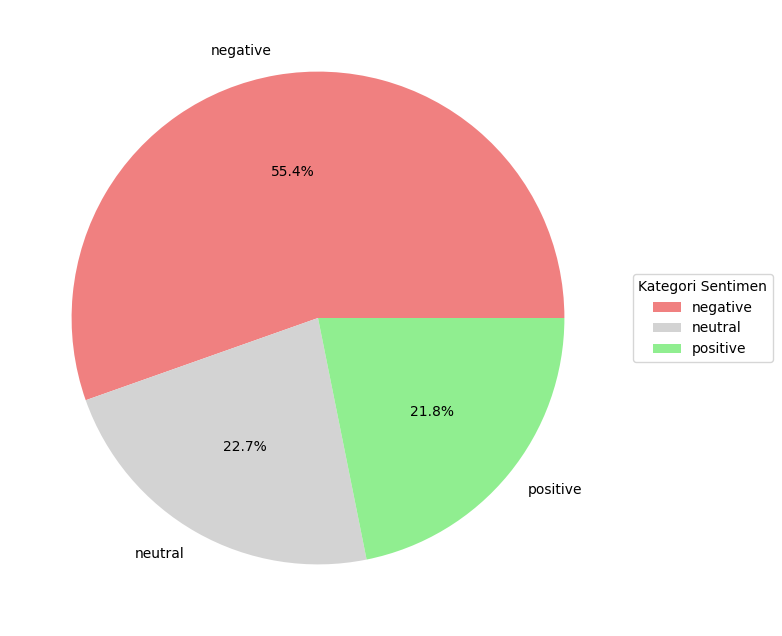

In [9]:
# Fungsi analisis sentimen
results = df_sample['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))

# Menambahkan kolom untuk score dan polarity
df_sample['sentiment_score'] = results[0]  # Nilai score mentah
df_sample['polarity_score'] = results[0]   
df_sample['polarity'] = results[1]         # Label sentimen (positif/negatif/netral)

# Contoh baris untuk cek
print("\nContoh beberapa baris data:")
print(df_sample[['text_stopword', 'sentiment_score', 'polarity']].head())

# Distribusi sentiment
print("\nDistribusi sentiment:")
polarity_counts = df_sample['polarity'].value_counts()
print(polarity_counts)

# Chart
plt.figure(figsize=(10, 8))
plt.pie(polarity_counts.values, 
        labels=polarity_counts.index,
        autopct='%1.1f%%',
        colors=['lightcoral', 'lightgray', 'lightgreen'])  

plt.legend(polarity_counts.index, 
          title="Kategori Sentimen",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

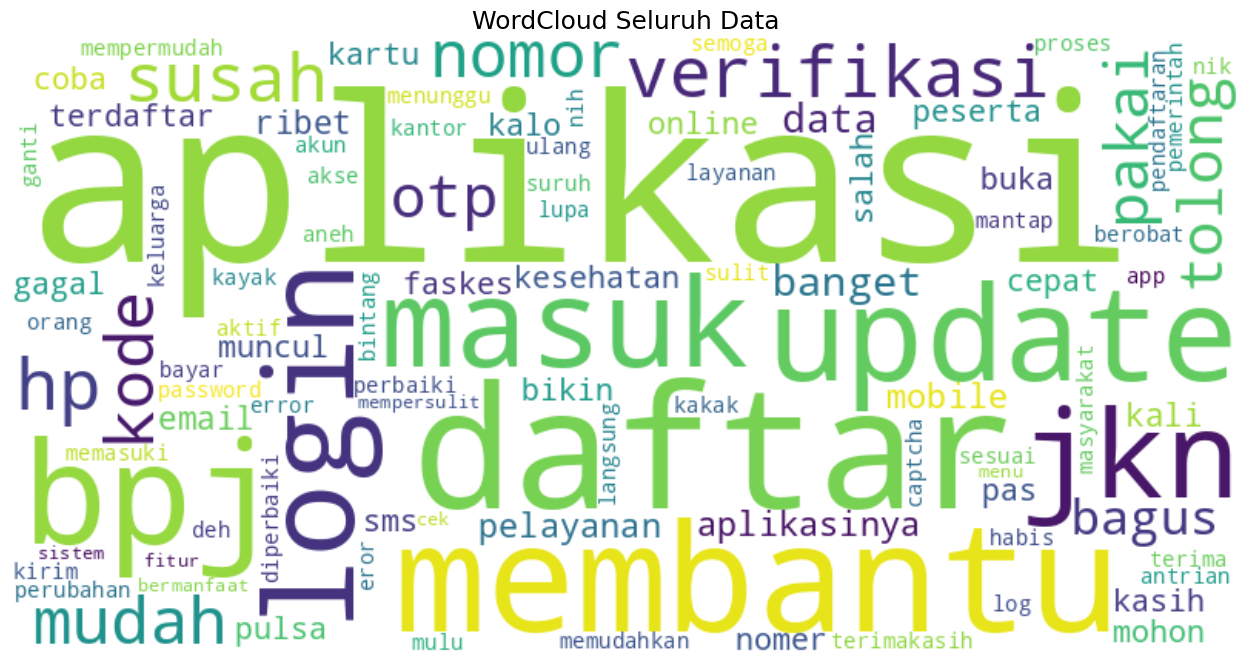

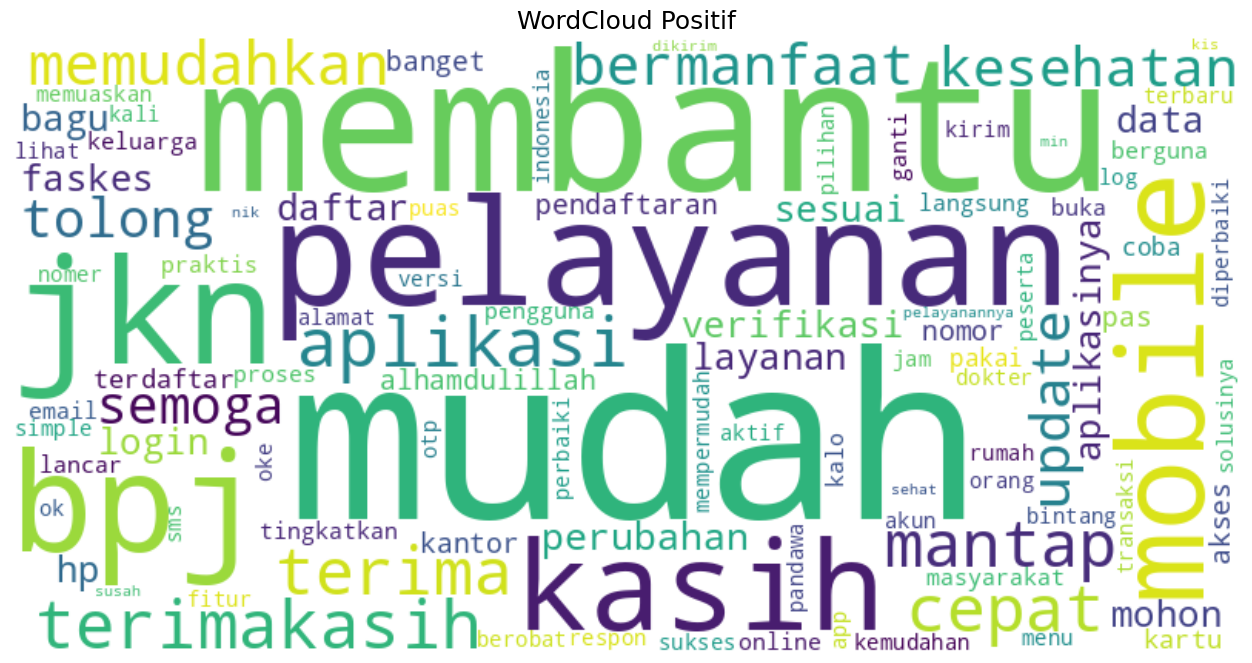

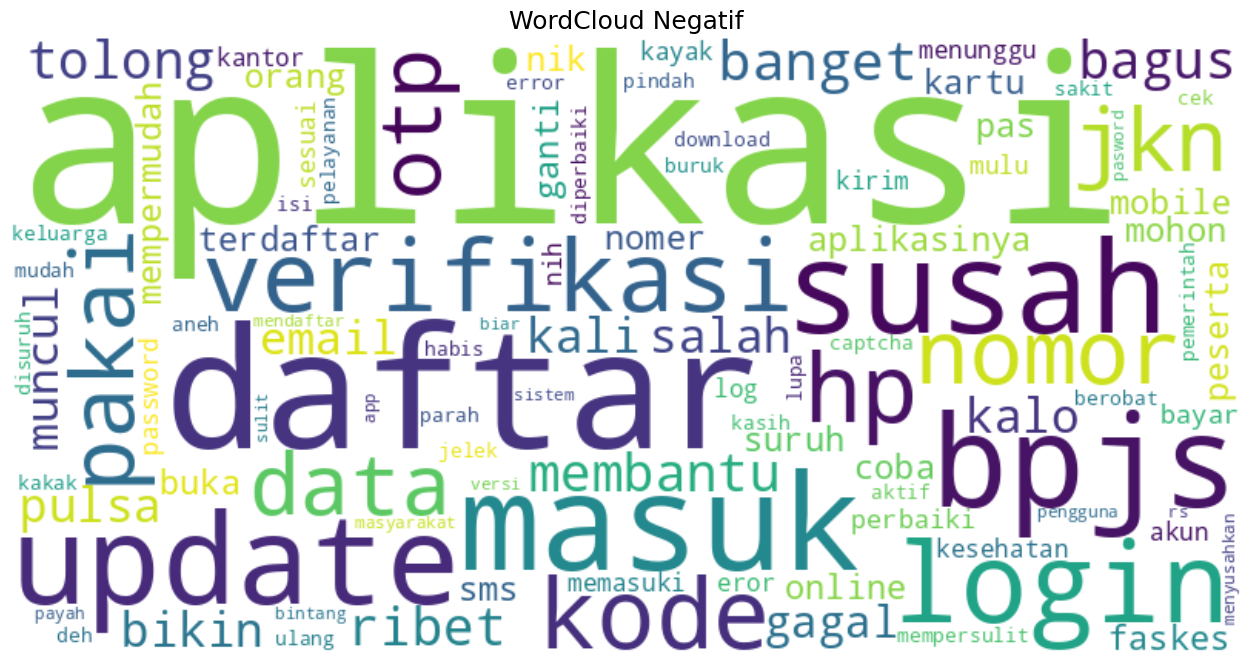

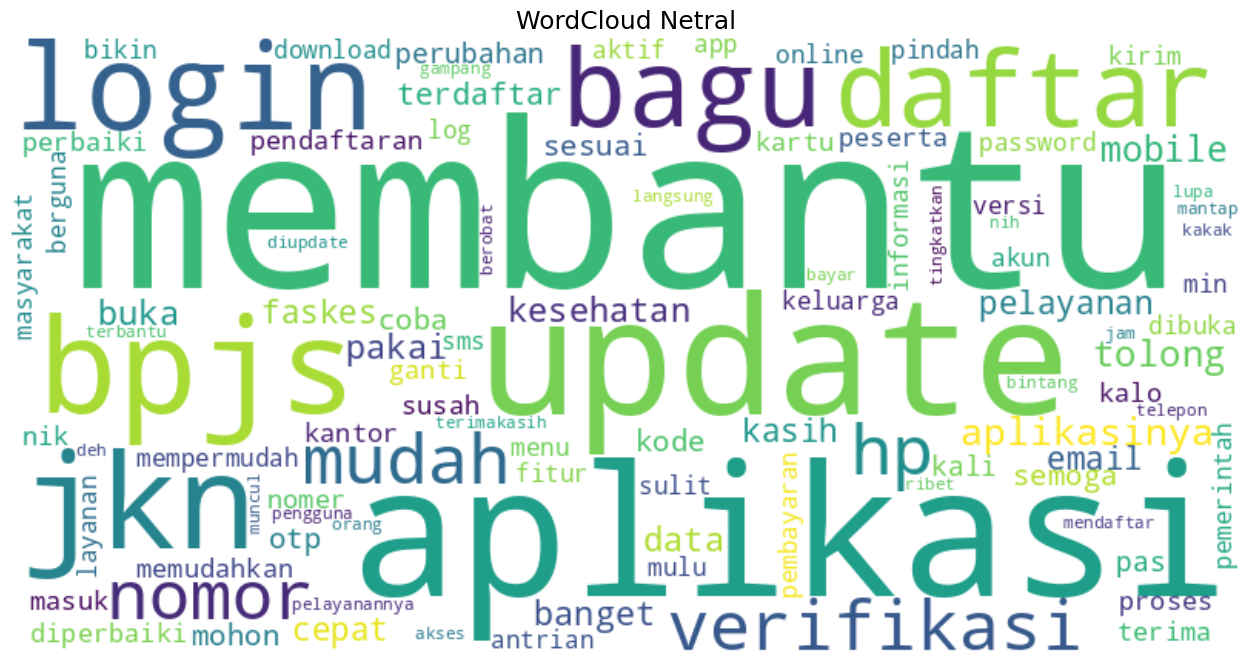

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function untuk membuat wordcloud, hanya mengambil sampel acak karena datanya sangat besar
def create_wordcloud(df, sentiment='all', title_suffix=''):
    if sentiment.lower() != 'all':
        df = df[df['polarity'] == sentiment]
        
    df_subset = df.sample(frac=0.2, random_state=42)

    text = ' '.join([word for sublist in df_subset['text_stopword'] for word in sublist])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        collocations=False,
        max_font_size=150,
        colormap='viridis'
    ).generate(text)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    title = f'WordCloud {title_suffix}'
    plt.title(title, fontsize=18)
    plt.show()

create_wordcloud(df_sample, sentiment='all', title_suffix='Seluruh Data')

create_wordcloud(df_sample, sentiment='positive', title_suffix='Positif')
create_wordcloud(df_sample, sentiment='negative', title_suffix='Negatif')
create_wordcloud(df_sample, sentiment='neutral', title_suffix='Netral')


In [11]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54875 entries, 10 to 98999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              54875 non-null  object
 1   userName              54875 non-null  object
 2   userImage             54875 non-null  object
 3   content               54875 non-null  object
 4   score                 54875 non-null  int64 
 5   thumbsUpCount         54875 non-null  int64 
 6   reviewCreatedVersion  54875 non-null  object
 7   at                    54875 non-null  object
 8   replyContent          54875 non-null  object
 9   repliedAt             54875 non-null  object
 10  appVersion            54875 non-null  object
 11  text_clean            54875 non-null  object
 12  text_casefoldingText  54875 non-null  object
 13  text_slangwords       54875 non-null  object
 14  text_tokenizingText   54875 non-null  object
 15  text_stopword         54875 non-null  ob

In [12]:
# Menghitung rata-rata kata dalam kalimat
def hitung_kata_dataframe(df, kolom):
    df['jumlah_kata'] = df[kolom].str.split().str.len()
    
    rata_rata_kata = df['jumlah_kata'].mean()
    
    return df, rata_rata_kata
hasil = hitung_kata_dataframe(df_sample, 'text_akhir')
print("Jumlah kata per baris:")
# print(df[['text_stopword', 'jumlah_kata']])
print(f"\nRata-rata jumlah kata: {hasil[1]:.2f}")

Jumlah kata per baris:

Rata-rata jumlah kata: 8.20


Ini membantu menentukan panjang kalimat untuk input nanti

## 4. Feature Extraction and Modeling

### 1. Model : CNN,    Ekstraksi Fitur: Embedding    Pembagian Data: 80/20

Epoch 1/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6014 - loss: 0.8704 - val_accuracy: 0.8433 - val_loss: 0.4835
Epoch 2/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8779 - loss: 0.3412 - val_accuracy: 0.9098 - val_loss: 0.2804
Epoch 3/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9318 - loss: 0.1968 - val_accuracy: 0.9218 - val_loss: 0.2331
Epoch 4/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9488 - loss: 0.1446 - val_accuracy: 0.9208 - val_loss: 0.2169
Epoch 5/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9577 - loss: 0.1163 - val_accuracy: 0.9219 - val_loss: 0.2102
Epoch 6/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9649 - loss: 0.0993 - val_accuracy: 0.9220 - val_loss: 0.2117
Epoch 7/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9688 - loss: 0.0852 - val_accuracy: 0.9210 - val_loss: 0.2130
Epoch 8/9
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9708 - loss: 0.0783 - val_accuracy: 0.9202 - v

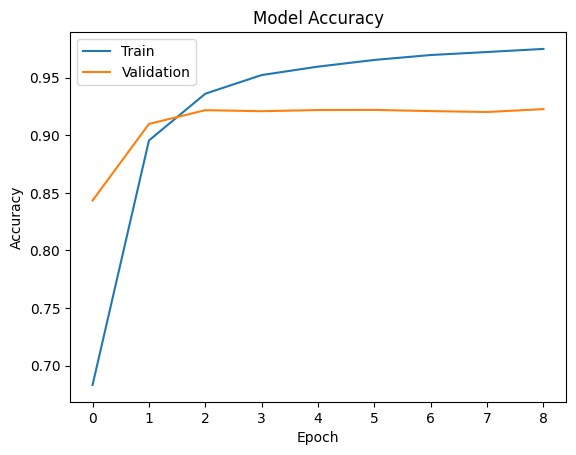

343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9231 - loss: 0.2169    


In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

X = df_sample['text_akhir'] # Memakai string 
y = df_sample['polarity'].astype('category').cat.codes
# print(df_sample['polarity'].astype('category').cat.codes)

# Set seed untuk reproduksi random kata 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# tokenisasi kata
tokenizer = Tokenizer(num_words=20000) 
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = 21 # karena rata-rata kata pendek
X_pad = pad_sequences(sequences, maxlen=max_len)

# Penjelasan mudahnya : 
# Mengambil 30000 kata yang paling sering muncul; yang diluar = dihapus
# Setelah semua punya nilai, jadi sequences ; contoh : aduh begitu ini jelek = [234, 56, 789, 12]
# max_len untuk sequence [234, 56, 789, 12, 345, 567, 0, 0, 0, ..., 0] 


# membuat model dan embedding
model = Sequential()
# Layer 1: Embedding (Mengubah kata menjadi vektor)
model.add(Embedding(
    input_dim=20001, # indeks 0-20000 
    output_dim=150)) # Setiap kata jadi vektor 150 dimensi
# Layer 2 & 3: Konvolusi 1D (Mencari pola lokal dalam kalimat)
model.add(Conv1D(256, 2, activation='relu', padding='same'))  
# 2 kata berturut-turut (saya suka ), (suka makan ) 
# 256 pola yang dicari e.g positif + negatif, sifat + benda, .. > = makin kompleks mendeteksi pola
# padding untuk nilai input di layer selanjutnya dan layer sekarang sama, 
model.add(Dropout(0.4)) # tambah dropout untuk mencegah overfitting 
model.add(Conv1D(256, 5, activation='relu', padding='same'))  
model.add(Dropout(0.4)) 
model.add(GlobalMaxPooling1D()) # vektor menyesuaikan dengan layer konvolusi
# Ambil nilai tertinggi dari setiap filter → pola paling kentara. e.g "tidak + ... " untuk kombinasi kata segmen negatif

model.add(Dense(128, activation='relu')) 
# memakai relu untuk mengatasi masalah vanishing gradient 
model.add(Dropout(0.4)) 
model.add(Dense(3, activation='softmax'))  

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=SEED)

optimizer = Adam(learning_rate=0.0001) # pakai learning rate kecil agak mengurangi fluktuasi val accuracy
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # karena bentuk data adalah label, bukan one-hot encoding, to_categorical(y) jika ingin one_hot
    metrics=['accuracy']
)

history = model.fit(
    X_train, 
    y_train,
    epochs=9,
    batch_size=64,
    validation_split=0.2, #untuk validasi performa data, seperti kuis  
    shuffle=True
)


# cek prediksi model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# evaluasi dengan data baru, seperti ujian akhir
model.evaluate(X_test, y_test)

# Simpan, karena model terbaik
model.save("cnn_sentiment_model.h5")

# Simpan tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Simpan label mapping (karena label awal berupa string)
label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
import json
with open('label_mapping.json', 'w') as f:
    json.dump(label_mapping, f)

Model sedikit mengalami overfitting sepertinya, bisa mengurangi epochnya, menerapkan early_stopping, atau metode lainnya.  

### 2. Model : LTSM + CNN (relu),    Ekstraksi Fitur: Word2Vec    Pembagian Data: 80/20

Epoch 1/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5997 - loss: 0.8780 - val_accuracy: 0.7341 - val_loss: 0.6700
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7476 - loss: 0.6307 - val_accuracy: 0.7819 - val_loss: 0.5495
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7859 - loss: 0.5316 - val_accuracy: 0.8059 - val_loss: 0.4820
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8126 - loss: 0.4682 - val_accuracy: 0.8246 - val_loss: 0.4399
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8304 - loss: 0.4253 - val_accuracy: 0.8312 - val_loss: 0.4184
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8414 - loss: 0.3940 - val_accuracy: 0.8465 - val_loss: 0.3857
Epoch 7/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8557 - loss: 0.3626 - val_accuracy: 0.8513 - val_loss: 0.3621
Epoch 8/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8625 - loss: 0.3375 - val_accu

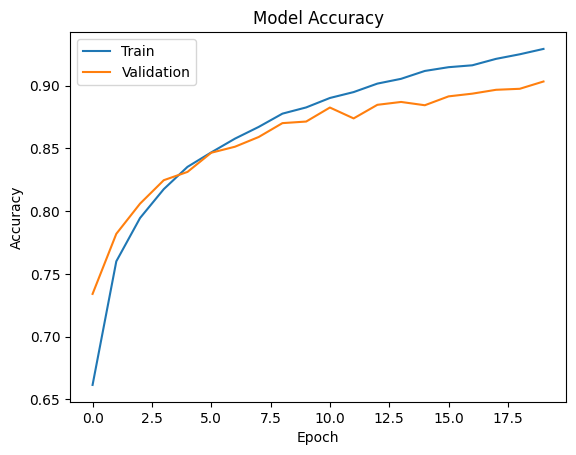

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8997 - loss: 0.2654
Test accuracy: 0.9014


In [47]:
from gensim.models import Word2Vec
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import random
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

X = df_sample['text_akhir']
y = df_sample['polarity'].astype('category').cat.codes

tokenizer = Tokenizer(num_words=20000) 
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = 20 
X_pad = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

sentences = [[word for word in text.split() if word in tokenizer.word_index] for text in X]
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=7, seed=SEED)
# Buat vektor 100-dimensi dari kata-kata di data.
# melihat 3 kata sebelum/sesudah kata target.
# Minimal kemunculan kata untuk diproses = 7
    
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:  
        embedding_matrix[i] = w2v_model.wv[word]
        # Gunakan vektor Word2Vec sebagai bobot awal di layer embedding.
# Model
model = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=True), 
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)), # Menangkap konteks maju-mundur
    LSTM(64, dropout=0.2), # gaada alasan khusus, tetapi biasanya lebih baik memperkecil unit neuron
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=SEED, stratify=y) # seimbangkan data

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2, 
    shuffle=True
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_results = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_results[1]:.4f}")

### 3. Model : GRU,    Ekstraksi Fitur: Word2Vec,    Pembagian Data: 70/30

Epoch 1/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6014 - loss: 0.8853 - val_accuracy: 0.7145 - val_loss: 0.7089
Epoch 2/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7279 - loss: 0.6693 - val_accuracy: 0.7427 - val_loss: 0.6265
Epoch 3/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7625 - loss: 0.5951 - val_accuracy: 0.7758 - val_loss: 0.5633
Epoch 4/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7918 - loss: 0.5259 - val_accuracy: 0.8018 - val_loss: 0.5051
Epoch 5/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8137 - loss: 0.4740 - val_accuracy: 0.8123 - val_loss: 0.4705
Epoch 6/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8349 - loss: 0.4270 - val_accuracy: 0.8277 - val_loss: 0.4401
Epoch 7/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8498 - loss: 0.3908 - val_accuracy: 0.8387 - val_loss: 0.4148
Epoch 8/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8555 - loss: 0.3652 - val_accu

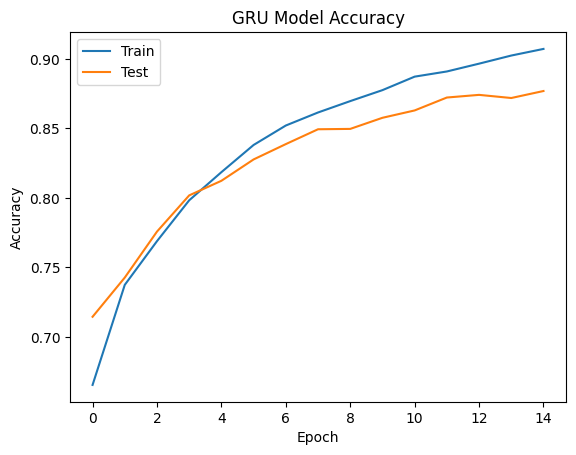

515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8786 - loss: 0.2974
Test Accuracy: 0.8813


In [50]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.layers import GRU, Dense, Embedding
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

X = df_sample['text_akhir']
y = df_sample['polarity'].astype('category').cat.codes 

tokenizer = Tokenizer(num_words=20000) 
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = 20
X_pad = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

sentences = [[word for word in text.split() if word in tokenizer.word_index] for text in X]
w2v_model = Word2Vec(sentences, vector_size=150, window=3, min_count=7, seed=SEED)

embedding_dim = 150
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True  
    ),
    GRU(128, dropout=0.3, return_sequences=False), 
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.3, random_state=SEED, stratify=y)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.3,  
    shuffle=True
)

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')